In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_massver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_massver', 'train_mass_labels2_num.npy'))
    #FN = np.load(os.path.join('../Data_final_massver', 'train_mass_FN.npy'))
    return images, labels#, FN


def load_testing():
    images = np.load(os.path.join('../Data_final_massver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_massver', 'test_mass_labels2_num.npy'))
    #FN = np.load(os.path.join('../Data_final_massver', 'test_mass_FN.npy'))
    return images, labels#, FN

In [3]:
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 1390 	 Test size: 306
Image size: 256x256


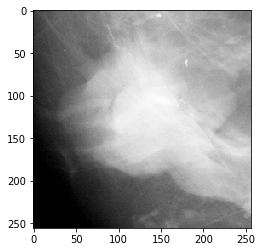

Label: 1


In [4]:
idx = 10

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
#print("FN: " + str(test_FN[idx]))

In [5]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
train_images.shape

(1390, 256, 256, 1)

In [7]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [8]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [10]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [11]:
def create_vgg19(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg19_base = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg19 = models.Sequential()
    vgg19.add(vgg19_base)

    vgg19.add(layers.Flatten())
    if dropout is not None:
        vgg19.add(layers.Dropout(dropout))
    vgg19.add(layers.Dense(1024, activation='relu'))
    vgg19.add(layers.Dense(fc_size, activation='relu'))
    vgg19.add(layers.Dense(output, activation='softmax'))

    vgg19_base.trainable = False
    
    if verbose:
        vgg19_base.summary()
        vgg19.summary()

    return vgg19

In [12]:
vgg = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
for layer in vgg.layers:
    layer.trainable = False
vgg_maxpool = vgg.get_layer('block5_pool').output
FeatureFlatten = Flatten()(vgg_maxpool)
dense1 = Dense(1024, name = 'dense1', activation = 'relu')(FeatureFlatten)
dense2 = Dense(128, name = 'dense2', activation = 'relu')(dense1)
predictions = Dense(2, name = 'predictions', activation = 'softmax')(dense2)

new_vgg = Model(inputs = vgg.input, outputs = predictions)
new_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [13]:
vgg19_mass_benign_or_malignant_best_Adam = new_vgg

In [14]:
vgg19_mass_benign_or_malignant_best_RMSprop = new_vgg

In [22]:
vgg19_mass_benign_or_malignant_best_Adam = create_vgg19(dropout=0.5, fc_size=128, output = 2)

In [23]:
vgg19_mass_benign_or_malignant_best_Adam.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 33,686,914
Non-trainable params: 14,714,688
___________________________________

### Adam

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_mass_benign_or_malignant_best_Adam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_mass_benign_or_malignant_best_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_vgg19_mass_benign_or_malignant_best_Adam = vgg19_mass_benign_or_malignant_best_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 2.5618 - recall: 0.4941
Epoch 00001: val_loss improved from inf to 1.28394, saving model to ../model/vgg19_mass_benign_or_malignant_best_Adam.h5
5/5 [==============================] - 14s 3s/step - loss: 2.2628 - recall: 0.5094 - val_loss: 1.2839 - val_recall: 0.5252
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9905 - recall: 0.5212
Epoch 00002: val_loss improved from 1.28394 to 0.70758, saving model to ../model/vgg19_mass_benign_or_malignant_best_Adam.h5
5/5 [==============================] - 11s 2s/step - loss: 0.9921 - recall: 0.5250 - val_loss: 0.7076 - val_recall: 0.6007
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7786 - recall: 0.5703
Epoch 00003: val_loss improved from 0.70758 to 0.61573, saving model 

Epoch 28/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5960 - recall: 0.6737
Epoch 00028: val_loss did not improve from 0.55889
5/5 [==============================] - 10s 2s/step - loss: 0.5898 - recall: 0.6767 - val_loss: 0.5783 - val_recall: 0.7086
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5526 - recall: 0.7266
Epoch 00029: val_loss improved from 0.55889 to 0.53274, saving model to ../model/vgg19_mass_benign_or_malignant_best_Adam.h5
5/5 [==============================] - 11s 2s/step - loss: 0.5453 - recall: 0.7312 - val_loss: 0.5327 - val_recall: 0.7014
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5974 - recall: 0.6758
Epoch 00030: val_loss did not improve from 0.53274
5/5 [==============================] - 11s 2s/step - loss: 0.5913 - recall: 0.6828 - val_loss: 0.5788 - val_recall: 0.6439
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5911 - recall: 0.7140
Epoch 00031: val_loss did not improv

Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5573 - recall: 0.7227
Epoch 00059: val_loss did not improve from 0.53274
5/5 [==============================] - 11s 2s/step - loss: 0.5511 - recall: 0.7281 - val_loss: 0.6304 - val_recall: 0.6799
Epoch 00059: early stopping


In [17]:
models.save_model(vgg19_mass_benign_or_malignant_best_Adam, '../model/vgg19_mass_benign_or_malignant_end_Adam.h5')

In [18]:
tra_loss_fe = history_vgg19_mass_benign_or_malignant_best_Adam.history['loss']
tra_acc_fe = history_vgg19_mass_benign_or_malignant_best_Adam.history['recall']
val_loss_fe = history_vgg19_mass_benign_or_malignant_best_Adam.history['val_loss']
val_acc_fe = history_vgg19_mass_benign_or_malignant_best_Adam.history['val_recall']

In [19]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_mass_benign_or_malignant = models.load_model('../model/vgg19_mass_benign_or_malignant_best_Adam.h5')
test_loss_fe, test_acc_fe = vgg19_mass_benign_or_malignant_best_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

In [20]:
print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 59
Epoch [opt]: 29
Valid recall [end]: 0.6799
Valid recall [opt]: 0.7014
Test recall [end]:  0.6961
Test recall [opt]:  0.6569
Valid loss [end]: 0.6304
Valid loss [opt]: 0.5327
Test loss [end]:  0.6422
Test loss [opt]:  0.6358


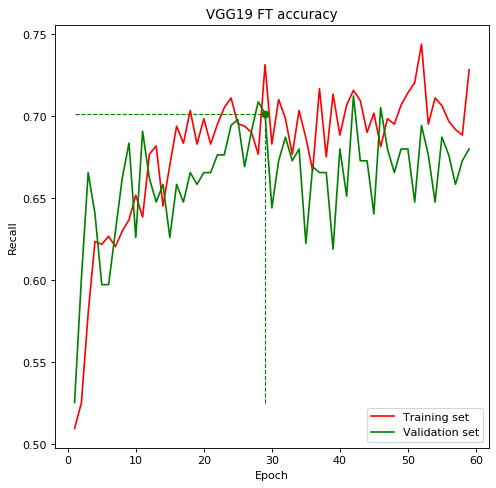

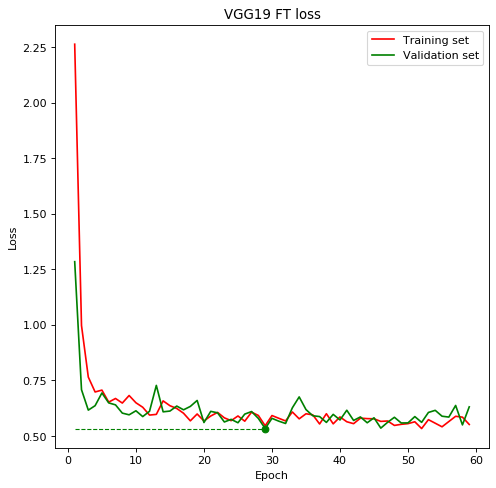

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [22]:
vgg19_mass_benign_or_malignant_best_SGD = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_mass_benign_or_malignant_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_mass_benign_or_malignant_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [23]:
# Train
history_vgg19_mass_benign_or_malignant_best_SGD = vgg19_mass_benign_or_malignant_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2976 - recall: 0.4619
Epoch 00001: val_loss improved from inf to 0.86617, saving model to ../model/vgg19_mass_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 11s 2s/step - loss: 1.2699 - recall: 0.4733 - val_loss: 0.8662 - val_recall: 0.5612
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0633 - recall: 0.5312
Epoch 00002: val_loss did not improve from 0.86617
5/5 [==============================] - 11s 2s/step - loss: 1.0493 - recall: 0.5469 - val_loss: 0.9165 - val_recall: 0.5180
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1634 - recall: 0.5059
Epoch 00003: val_loss did not improve from 0.86617
5/5 [==============================] - 11s 2s/step - loss: 1.1310 - recall: 0.5078 - val_loss: 0.9160 - val_recall: 0.4892
Epoch 4/300
4/5 [=======================>.....

4/5 [=======================>......] - ETA: 1s - loss: 0.8633 - recall: 0.5530
Epoch 00059: val_loss did not improve from 0.61180
5/5 [==============================] - 11s 2s/step - loss: 0.8556 - recall: 0.5683 - val_loss: 0.6640 - val_recall: 0.6007
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8551 - recall: 0.5684
Epoch 00060: val_loss did not improve from 0.61180
5/5 [==============================] - 10s 2s/step - loss: 0.8424 - recall: 0.5656 - val_loss: 0.7479 - val_recall: 0.5935
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8320 - recall: 0.5742
Epoch 00061: val_loss did not improve from 0.61180
5/5 [==============================] - 10s 2s/step - loss: 0.8369 - recall: 0.5783 - val_loss: 0.7368 - val_recall: 0.6223
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9352 - recall: 0.5352
Epoch 00062: val_loss did not improve from 0.61180
5/5 [==============================] - 10s 2s/step - loss: 0.9204 - reca

In [24]:
models.save_model(vgg19_mass_benign_or_malignant_best_SGD, '../model/vgg19_mass_benign_or_malignant_end_SGD.h5')

In [25]:
tra_loss_fe = history_vgg19_mass_benign_or_malignant_best_SGD.history['loss']
tra_acc_fe = history_vgg19_mass_benign_or_malignant_best_SGD.history['recall']
val_loss_fe = history_vgg19_mass_benign_or_malignant_best_SGD.history['val_loss']
val_acc_fe = history_vgg19_mass_benign_or_malignant_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_mass_benign_or_malignant = models.load_model('../model/vgg19_mass_benign_or_malignant_best_SGD.h5')
test_loss_fe, test_acc_fe = vgg19_mass_benign_or_malignant_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 72
Epoch [opt]: 42
Valid recall [end]: 0.6151
Valid recall [opt]: 0.6007
Test recall [end]:  0.6144
Test recall [opt]:  0.5948
Valid loss [end]: 0.6865
Valid loss [opt]: 0.6118
Test loss [end]:  0.8313
Test loss [opt]:  0.8681


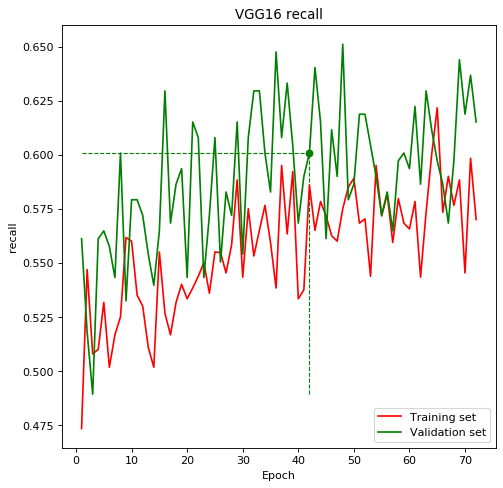

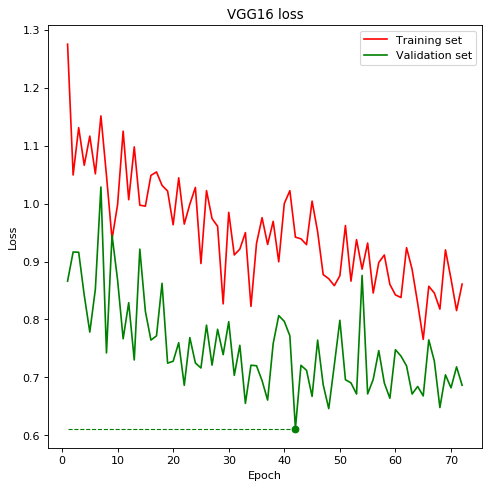

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [27]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_mass_benign_or_malignant_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_mass_benign_or_malignant_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [28]:
# Train
history_vgg19_mass_benign_or_malignant_best_RMSprop = vgg19_mass_benign_or_malignant_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2367 - recall: 0.5703
Epoch 00001: val_loss improved from inf to 0.65412, saving model to ../model/vgg19_mass_benign_or_malignant_best_RMSprop.h5
5/5 [==============================] - 11s 2s/step - loss: 1.1143 - recall: 0.5875 - val_loss: 0.6541 - val_recall: 0.6583
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6474 - recall: 0.6543
Epoch 00002: val_loss improved from 0.65412 to 0.64885, saving model to ../model/vgg19_mass_benign_or_malignant_best_RMSprop.h5
5/5 [==============================] - 12s 2s/step - loss: 0.6577 - recall: 0.6281 - val_loss: 0.6489 - val_recall: 0.6007
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6286 - recall: 0.6568
Epoch 00003: val_loss improved from 0.64885 to 0.63955, saving model to ../model/vgg19_mass_benign_or_malignant_best_RMSprop.h5
5/5 [======

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5659 - recall: 0.6907
Epoch 00029: val_loss did not improve from 0.53298
5/5 [==============================] - 10s 2s/step - loss: 0.5640 - recall: 0.6950 - val_loss: 0.6054 - val_recall: 0.6403
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6250 - recall: 0.6801
Epoch 00030: val_loss did not improve from 0.53298
5/5 [==============================] - 10s 2s/step - loss: 0.6148 - recall: 0.6967 - val_loss: 0.6053 - val_recall: 0.6835
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6037 - recall: 0.6928
Epoch 00031: val_loss did not improve from 0.53298
5/5 [==============================] - 10s 2s/step - loss: 0.5870 - recall: 0.7033 - val_loss: 0.5730 - val_recall: 0.6763
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5786 - recall: 0.6970
Epoch 00032: val_loss did not improve from 0.53298
5/5 [==============================] - 10s 2s/step - loss: 

In [29]:
models.save_model(vgg19_mass_benign_or_malignant_best_RMSprop, '../model/vgg19_mass_benign_or_malignant_end_RMSprop.h5')

In [30]:
tra_loss_fe = history_vgg19_mass_benign_or_malignant_best_RMSprop.history['loss']
tra_acc_fe = history_vgg19_mass_benign_or_malignant_best_RMSprop.history['recall']
val_loss_fe = history_vgg19_mass_benign_or_malignant_best_RMSprop.history['val_loss']
val_acc_fe = history_vgg19_mass_benign_or_malignant_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_mass_benign_or_malignant = models.load_model('../model/vgg19_mass_benign_or_malignant_best_RMSprop.h5')
test_loss_fe, test_acc_fe = vgg19_mass_benign_or_malignant_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 69
Epoch [opt]: 39
Valid accuracy [end]: 0.7014
Valid accuracy [opt]: 0.7230
Test accuracy [end]:  0.7418
Test accuracy [opt]:  0.6863
Valid loss [end]: 0.5747
Valid loss [opt]: 0.4884
Test loss [end]:  0.6068
Test loss [opt]:  0.6160


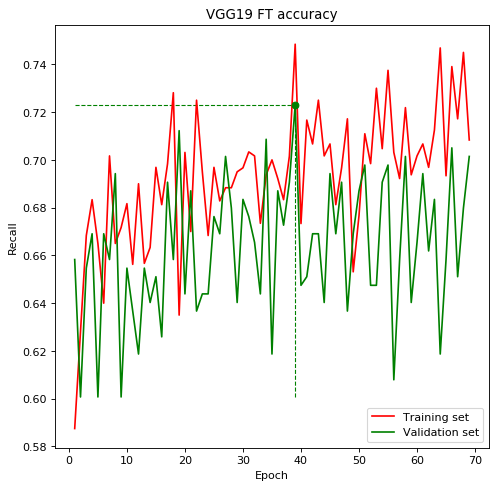

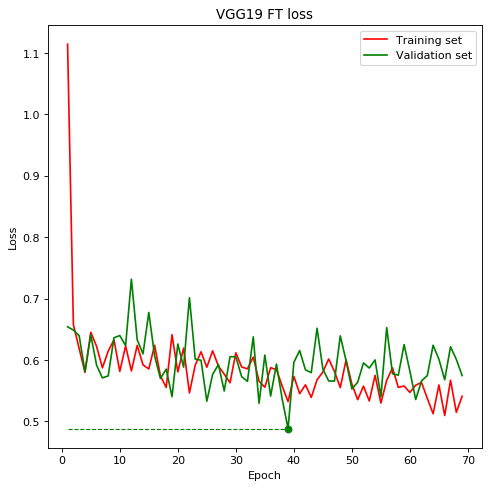

In [31]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [32]:
vgg19_mass_benign_or_malignant_best_Adadelta = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_mass_benign_or_malignant_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_mass_benign_or_malignant_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [33]:
# Train
history_vgg19_mass_benign_or_malignant_best_Adadelta = vgg19_mass_benign_or_malignant_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4825 - recall: 0.4746
Epoch 00001: val_loss improved from inf to 1.23674, saving model to ../model/vgg19_mass_benign_or_malignant_best_Adadelta.h5
5/5 [==============================] - 11s 2s/step - loss: 1.4599 - recall: 0.4703 - val_loss: 1.2367 - val_recall: 0.5216
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.5404 - recall: 0.4688
Epoch 00002: val_loss improved from 1.23674 to 1.23423, saving model to ../model/vgg19_mass_benign_or_malignant_best_Adadelta.h5
5/5 [==============================] - 12s 2s/step - loss: 1.6168 - recall: 0.4703 - val_loss: 1.2342 - val_recall: 0.4964
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.5120 - recall: 0.4619
Epoch 00003: val_loss improved from 1.23423 to 1.22934, saving model to ../model/vgg19_mass_benign_or_malignant_best_Adadelta.h5
5/5 [===

4/5 [=======================>......] - ETA: 1s - loss: 1.3809 - recall: 0.4805
Epoch 00029: val_loss did not improve from 0.93577
5/5 [==============================] - 11s 2s/step - loss: 1.3750 - recall: 0.5031 - val_loss: 1.1754 - val_recall: 0.5180
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1559 - recall: 0.4979
Epoch 00030: val_loss did not improve from 0.93577
5/5 [==============================] - 11s 2s/step - loss: 1.2244 - recall: 0.4900 - val_loss: 1.1564 - val_recall: 0.5072
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3001 - recall: 0.5000
Epoch 00031: val_loss did not improve from 0.93577
5/5 [==============================] - 10s 2s/step - loss: 1.2644 - recall: 0.5067 - val_loss: 1.0537 - val_recall: 0.5036
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2909 - recall: 0.4746
Epoch 00032: val_loss did not improve from 0.93577
5/5 [==============================] - 10s 2s/step - loss: 1.2356 - reca

Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2631 - recall: 0.4629
Epoch 00060: val_loss did not improve from 0.85498
5/5 [==============================] - 11s 2s/step - loss: 1.2453 - recall: 0.4734 - val_loss: 0.9613 - val_recall: 0.5252
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2238 - recall: 0.4936
Epoch 00061: val_loss did not improve from 0.85498
5/5 [==============================] - 11s 2s/step - loss: 1.1819 - recall: 0.5033 - val_loss: 0.9267 - val_recall: 0.4712
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1947 - recall: 0.5156
Epoch 00062: val_loss did not improve from 0.85498
5/5 [==============================] - 10s 2s/step - loss: 1.1823 - recall: 0.5150 - val_loss: 0.9059 - val_recall: 0.4820
Epoch 63/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2105 - recall: 0.4894
Epoch 00063: val_loss did not improve from 0.85498
5/5 [==============================] - 10s 2s/step - loss: 

In [34]:
models.save_model(vgg19_mass_benign_or_malignant_best_Adadelta, '../model/vgg19_mass_benign_or_malignant_end_Adadelta.h5')

In [35]:
tra_loss_fe = history_vgg19_mass_benign_or_malignant_best_Adadelta.history['loss']
tra_acc_fe = history_vgg19_mass_benign_or_malignant_best_Adadelta.history['recall']
val_loss_fe = history_vgg19_mass_benign_or_malignant_best_Adadelta.history['val_loss']
val_acc_fe = history_vgg19_mass_benign_or_malignant_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_mass_benign_or_malignant = models.load_model('../model/vgg19_mass_benign_or_malignant_best_Adadelta.h5')
test_loss_fe, test_acc_fe = vgg19_mass_benign_or_malignant_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 101
Epoch [opt]: 71
Valid accuracy [end]: 0.4712
Valid accuracy [opt]: 0.5252
Test accuracy [end]:  0.5458
Test accuracy [opt]:  0.5327
Valid loss [end]: 1.0462
Valid loss [opt]: 0.8443
Test loss [end]:  0.9942
Test loss [opt]:  1.0104


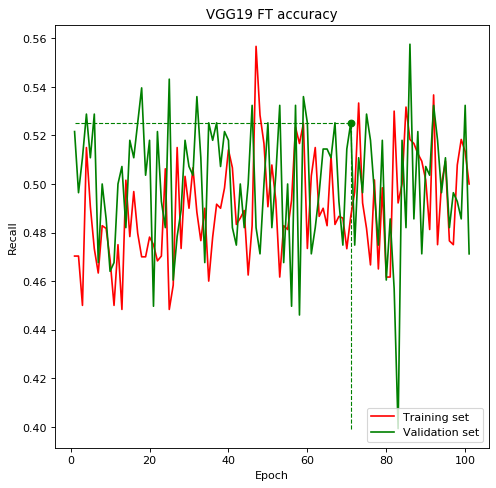

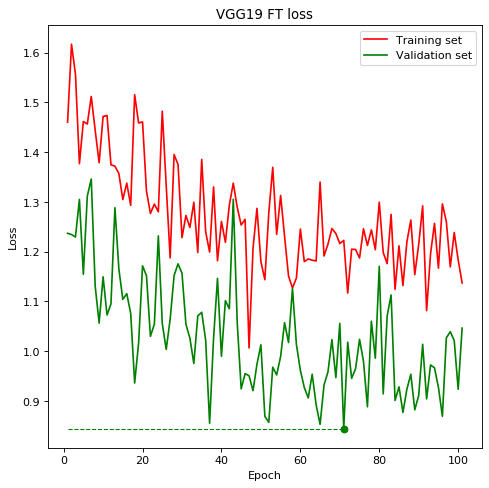

In [36]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [13]:
vgg19_mass_benign_or_malignant_best_Adagrad = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_mass_benign_or_malignant_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_mass_benign_or_malignant_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_vgg19_mass_benign_or_malignant_best_Adagrad = vgg19_mass_benign_or_malignant_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 3s - loss: 1.9383 - recall: 0.5636
Epoch 00001: val_loss improved from inf to 0.99726, saving model to ../model/vgg19_mass_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 18s 4s/step - loss: 1.8328 - recall: 0.5550 - val_loss: 0.9973 - val_recall: 0.5576
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1870 - recall: 0.5117
Epoch 00002: val_loss improved from 0.99726 to 0.83952, saving model to ../model/vgg19_mass_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 11s 2s/step - loss: 1.1255 - recall: 0.5281 - val_loss: 0.8395 - val_recall: 0.5791
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1141 - recall: 0.5684
Epoch 00003: val_loss did not improve from 0.83952
5/5 [=======

5/5 [==============================] - 11s 2s/step - loss: 0.9534 - recall: 0.5783 - val_loss: 0.6607 - val_recall: 0.6475
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9141 - recall: 0.5742
Epoch 00029: val_loss improved from 0.66066 to 0.63105, saving model to ../model/vgg19_mass_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 11s 2s/step - loss: 0.9393 - recall: 0.5609 - val_loss: 0.6310 - val_recall: 0.6367
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8363 - recall: 0.6250
Epoch 00030: val_loss did not improve from 0.63105
5/5 [==============================] - 11s 2s/step - loss: 0.8216 - recall: 0.6156 - val_loss: 0.7222 - val_recall: 0.6079
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8462 - recall: 0.6035
Epoch 00031: val_loss did not improve from 0.63105
5/5 [==============================] - 11s 2s/step - loss: 0.8236 - recall: 0.6117 - val_loss: 0.6743 - val_recall: 0.6763
Ep

4/5 [=======================>......] - ETA: 1s - loss: 0.7420 - recall: 0.6367
Epoch 00059: val_loss did not improve from 0.63105
5/5 [==============================] - 11s 2s/step - loss: 0.7458 - recall: 0.6422 - val_loss: 0.7418 - val_recall: 0.5863
Epoch 00059: early stopping


In [15]:
models.save_model(vgg19_mass_benign_or_malignant_best_Adagrad, '../model/vgg19_mass_benign_or_malignant_end_Adagrad.h5')

In [16]:
tra_loss_fe = history_vgg19_mass_benign_or_malignant_best_Adagrad.history['loss']
tra_acc_fe = history_vgg19_mass_benign_or_malignant_best_Adagrad.history['recall']
val_loss_fe = history_vgg19_mass_benign_or_malignant_best_Adagrad.history['val_loss']
val_acc_fe = history_vgg19_mass_benign_or_malignant_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_mass_benign_or_malignant = models.load_model('../model/vgg19_mass_benign_or_malignant_best_Adagrad.h5')
test_loss_fe, test_acc_fe = vgg19_mass_benign_or_malignant_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 59
Epoch [opt]: 29
Valid recall [end]: 0.5863
Valid recall [opt]: 0.6367
Test recall [end]:  0.5948
Test recall [opt]:  0.5752
Valid loss [end]: 0.7418
Valid loss [opt]: 0.6310
Test loss [end]:  0.8455
Test loss [opt]:  0.9194


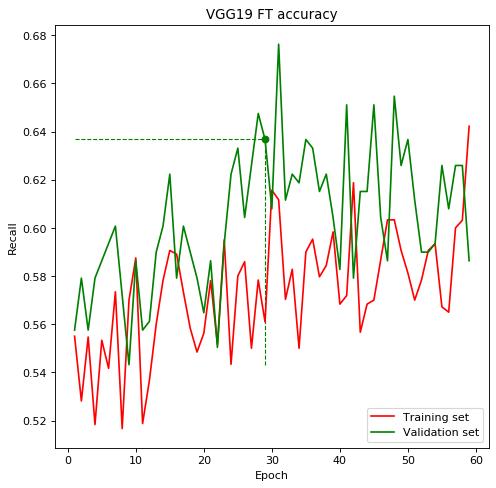

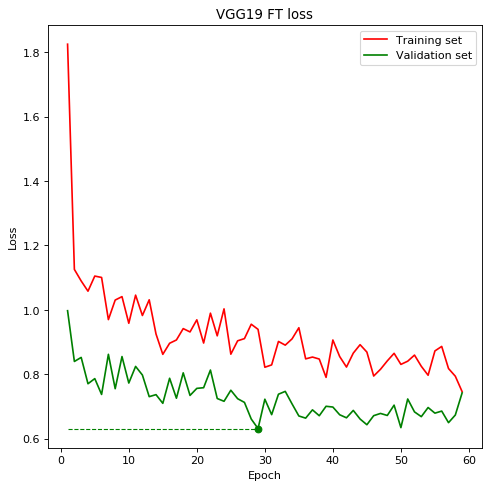

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [18]:
vgg19_mass_benign_or_malignant_best_Adamax = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_mass_benign_or_malignant_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_mass_benign_or_malignant_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [19]:
# Train
history_vgg19_mass_benign_or_malignant_best_Adamax = vgg19_mass_benign_or_malignant_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.6113 - recall: 0.4844
Epoch 00001: val_loss improved from inf to 0.72621, saving model to ../model/vgg19_mass_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 11s 2s/step - loss: 1.5883 - recall: 0.4850 - val_loss: 0.7262 - val_recall: 0.6295
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1201 - recall: 0.5593
Epoch 00002: val_loss did not improve from 0.72621
5/5 [==============================] - 11s 2s/step - loss: 1.0768 - recall: 0.5567 - val_loss: 0.7395 - val_recall: 0.6079
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8633 - recall: 0.6016
Epoch 00003: val_loss improved from 0.72621 to 0.64977, saving model to ../model/vgg19_mass_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 11s 2s/step - loss: 0.8656 - recall: 0.5967 - val_l

Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6893 - recall: 0.6562
Epoch 00030: val_loss did not improve from 0.59782
5/5 [==============================] - 10s 2s/step - loss: 0.7038 - recall: 0.6406 - val_loss: 0.6618 - val_recall: 0.6259
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6494 - recall: 0.6250
Epoch 00031: val_loss improved from 0.59782 to 0.59217, saving model to ../model/vgg19_mass_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 12s 2s/step - loss: 0.6845 - recall: 0.6117 - val_loss: 0.5922 - val_recall: 0.7050
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6846 - recall: 0.6387
Epoch 00032: val_loss did not improve from 0.59217
5/5 [==============================] - 10s 2s/step - loss: 0.6917 - recall: 0.6344 - val_loss: 0.6135 - val_recall: 0.6511
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6814 - recall: 0.6462
Epoch 00033: val_loss did not impr

In [20]:
models.save_model(vgg19_mass_benign_or_malignant_best_Adamax, '../model/vgg19_mass_benign_or_malignant_end_Adamax.h5')

In [21]:
tra_loss_fe = history_vgg19_mass_benign_or_malignant_best_Adamax.history['loss']
tra_acc_fe = history_vgg19_mass_benign_or_malignant_best_Adamax.history['recall']
val_loss_fe = history_vgg19_mass_benign_or_malignant_best_Adamax.history['val_loss']
val_acc_fe = history_vgg19_mass_benign_or_malignant_best_Adamax.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_mass_benign_or_malignant = models.load_model('../model/vgg19_mass_benign_or_malignant_best_Adamax.h5')
test_loss_fe, test_acc_fe = vgg19_mass_benign_or_malignant_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 81
Epoch [opt]: 51
Valid recall [end]: 0.6727
Valid recall [opt]: 0.6367
Test recall [end]:  0.6830
Test recall [opt]:  0.6830
Valid loss [end]: 0.5860
Valid loss [opt]: 0.5815
Test loss [end]:  0.6238
Test loss [opt]:  0.6468


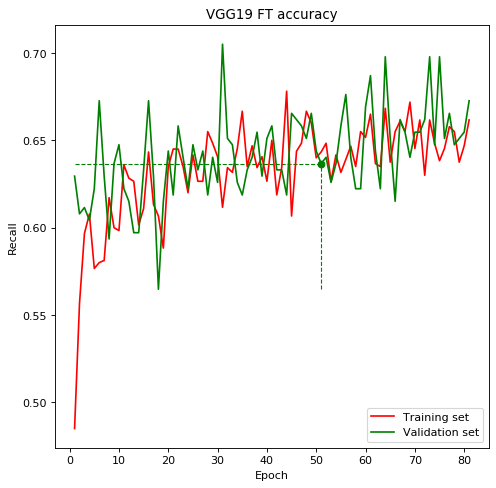

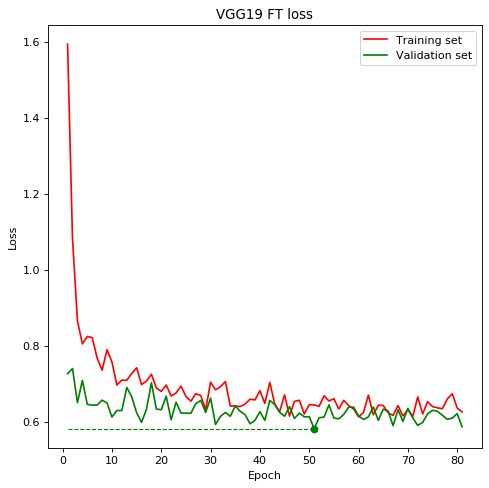

In [22]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [13]:
vgg19_mass_benign_or_malignant_best_Nadam = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_mass_benign_or_malignant_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_mass_benign_or_malignant_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_vgg19_mass_benign_or_malignant_best_Nadam = vgg19_mass_benign_or_malignant_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 1.8424 - recall: 0.5508
Epoch 00001: val_loss improved from inf to 0.78056, saving model to ../model/vgg19_mass_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 14s 3s/step - loss: 1.6908 - recall: 0.5578 - val_loss: 0.7806 - val_recall: 0.6007
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8969 - recall: 0.5784
Epoch 00002: val_loss improved from 0.78056 to 0.73187, saving model to ../model/vgg19_mass_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 11s 2s/step - loss: 0.9125 - recall: 0.5883 - val_loss: 0.7319 - val_recall: 0.5827
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9804 - recall: 0.5410
Epoch 00003: val_loss improved from 0.73187 to 0.63573, saving mode

4/5 [=======================>......] - ETA: 1s - loss: 0.6130 - recall: 0.6562
Epoch 00058: val_loss improved from 0.57519 to 0.56205, saving model to ../model/vgg19_mass_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 11s 2s/step - loss: 0.5975 - recall: 0.6703 - val_loss: 0.5620 - val_recall: 0.6942
Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5798 - recall: 0.7207
Epoch 00059: val_loss did not improve from 0.56205
5/5 [==============================] - 11s 2s/step - loss: 0.5981 - recall: 0.6906 - val_loss: 0.6018 - val_recall: 0.6655
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6041 - recall: 0.6822
Epoch 00060: val_loss did not improve from 0.56205
5/5 [==============================] - 11s 2s/step - loss: 0.6044 - recall: 0.6833 - val_loss: 0.5896 - val_recall: 0.6799
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5973 - recall: 0.6816
Epoch 00061: val_loss did not improve from 0.562

In [15]:
models.save_model(vgg19_mass_benign_or_malignant_best_Nadam, '../model/vgg19_mass_benign_or_malignant_end_Nadam.h5')

In [16]:
tra_loss_fe = history_vgg19_mass_benign_or_malignant_best_Nadam.history['loss']
tra_acc_fe = history_vgg19_mass_benign_or_malignant_best_Nadam.history['recall']
val_loss_fe = history_vgg19_mass_benign_or_malignant_best_Nadam.history['val_loss']
val_acc_fe = history_vgg19_mass_benign_or_malignant_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_mass_benign_or_malignant = models.load_model('../model/vgg19_mass_benign_or_malignant_best_Nadam.h5')
test_loss_fe, test_acc_fe = vgg19_mass_benign_or_malignant_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 115
Epoch [opt]: 85
Valid recall [end]: 0.6799
Valid recall [opt]: 0.7050
Test recall [end]:  0.6830
Test recall [opt]:  0.6830
Valid loss [end]: 0.5774
Valid loss [opt]: 0.5363
Test loss [end]:  0.6721
Test loss [opt]:  0.6329


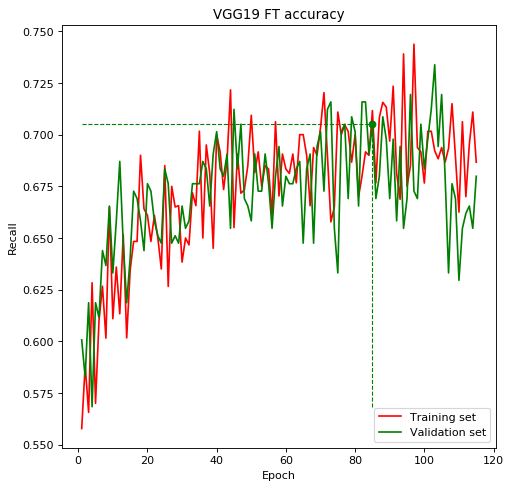

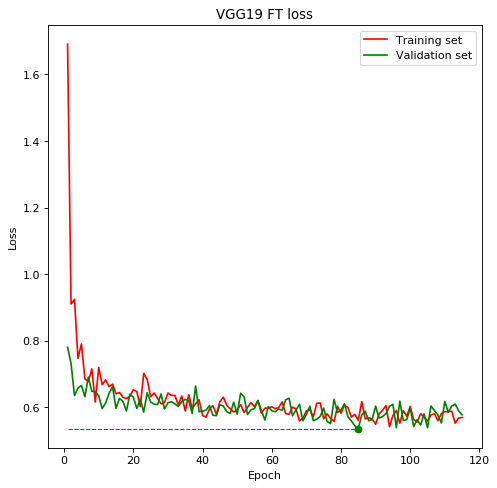

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [18]:
vgg19_mass_benign_or_malignant_fine_RMSprop = models.load_model('../model/vgg19_mass_benign_or_malignant_best_RMSprop.h5')

for layer in vgg19_mass_benign_or_malignant_fine_RMSprop.layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_mass_benign_or_malignant_fine_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg19_mass_benign_or_malignant_fine_RMSprop.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [19]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_mass_benign_or_malignant_fine_RMSprop_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [20]:
history_fit = vgg19_mass_benign_or_malignant_fine_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6840 - recall: 0.6543
Epoch 00001: val_loss improved from inf to 0.59494, saving model to ../model/vgg19_mass_benign_or_malignant_fine_RMSprop_best.h5
5/5 [==============================] - 11s 2s/step - loss: 0.6655 - recall: 0.6578 - val_loss: 0.5949 - val_recall: 0.6619
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5594 - recall: 0.7168
Epoch 00002: val_loss did not improve from 0.59494
5/5 [==============================] - 11s 2s/step - loss: 0.5409 - recall: 0.7328 - val_loss: 0.6267 - val_recall: 0.6655
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5576 - recall: 0.7031
Epoch 00003: val_loss improved from 0.59494 to 0.57618, saving model to ../model/vgg19_mass_benign_or_malignant_fine_RMSprop_best.h5
5/5 [==============================] - 12s 2s/step - loss: 0.5482 - recall: 0.

5/5 [==============================] - 10s 2s/step - loss: 0.5255 - recall: 0.7183 - val_loss: 0.5029 - val_recall: 0.7266
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5168 - recall: 0.7637
Epoch 00030: val_loss did not improve from 0.50291
5/5 [==============================] - 10s 2s/step - loss: 0.5174 - recall: 0.7594 - val_loss: 0.5246 - val_recall: 0.7302
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5091 - recall: 0.7441
Epoch 00031: val_loss did not improve from 0.50291
5/5 [==============================] - 11s 2s/step - loss: 0.5204 - recall: 0.7344 - val_loss: 0.5475 - val_recall: 0.6906
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5519 - recall: 0.6843
Epoch 00032: val_loss did not improve from 0.50291
5/5 [==============================] - 11s 2s/step - loss: 0.5373 - recall: 0.6933 - val_loss: 0.5385 - val_recall: 0.6763
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5257 - re

4/5 [=======================>......] - ETA: 1s - loss: 0.4708 - recall: 0.7734
Epoch 00060: val_loss did not improve from 0.49319
5/5 [==============================] - 10s 2s/step - loss: 0.4894 - recall: 0.7672 - val_loss: 0.5868 - val_recall: 0.6799
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5077 - recall: 0.7691
Epoch 00061: val_loss did not improve from 0.49319
5/5 [==============================] - 10s 2s/step - loss: 0.5015 - recall: 0.7667 - val_loss: 0.5327 - val_recall: 0.7230
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5050 - recall: 0.7383
Epoch 00062: val_loss did not improve from 0.49319
5/5 [==============================] - 10s 2s/step - loss: 0.4965 - recall: 0.7422 - val_loss: 0.5309 - val_recall: 0.7266
Epoch 63/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4859 - recall: 0.7669
Epoch 00063: val_loss did not improve from 0.49319
5/5 [==============================] - 11s 2s/step - loss: 0.4725 - reca

In [21]:
models.save_model(vgg19_mass_benign_or_malignant_fine_RMSprop, '../model/vgg19_mass_benign_or_malignant_fine_RMSprop_end.h5')

In [22]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_mass_benign_or_malignant_fine_RMSprop = models.load_model('../model/vgg19_mass_benign_or_malignant_fine_RMSprop_best.h5')
test_loss_fe, test_acc_fe = vgg19_mass_benign_or_malignant_fine_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_mass_benign_or_malignant_fine_RMSprop.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning

Epoch [end]: 86
Epoch [opt]: 56
Valid recall [end]: 0.6763
Valid recall [opt]: 0.7590
Test recall [end]:  0.7353
Test recall [opt]:  0.7157
Valid loss [end]: 0.6194
Valid loss [opt]: 0.4932
Test loss [end]:  0.5945
Test loss [opt]:  0.6036


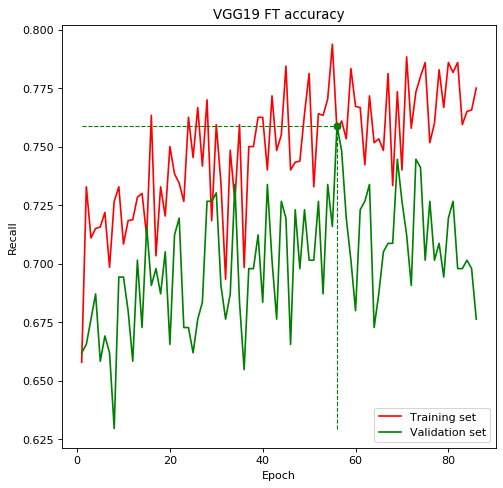

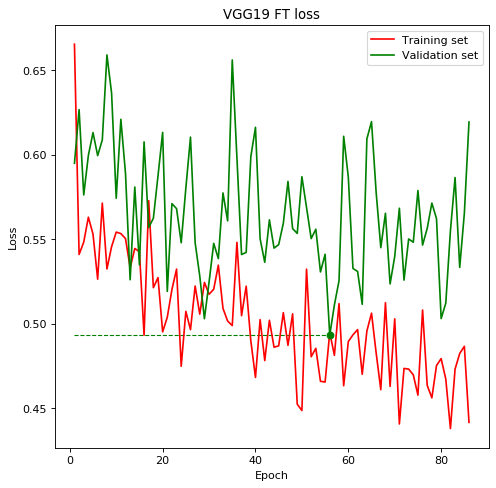

In [23]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [13]:
vgg19_mass_benign_or_malignant_fine_RMSprop2 = models.load_model('../model/vgg19_mass_benign_or_malignant_fine_RMSprop_best.h5')

for layer in vgg19_mass_benign_or_malignant_fine_RMSprop2.layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_mass_benign_or_malignant_fine_RMSprop2.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg19_mass_benign_or_malignant_fine_RMSprop2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [14]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_mass_benign_or_malignant_fine_RMSprop_best2.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [15]:
history_fit = vgg19_mass_benign_or_malignant_fine_RMSprop2.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 0.7521 - recall: 0.6309
Epoch 00001: val_loss improved from inf to 0.66745, saving model to ../model/vgg19_mass_benign_or_malignant_fine_RMSprop_best2.h5
5/5 [==============================] - 17s 3s/step - loss: 0.7198 - recall: 0.6433 - val_loss: 0.6674 - val_recall: 0.6619
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6006 - recall: 0.6875
Epoch 00002: val_loss improved from 0.66745 to 0.57417, saving model to ../model/vgg19_mass_benign_or_malignant_fine_RMSprop_best2.h5
5/5 [==============================] - 10s 2s/step - loss: 0.6004 - recall: 0.6766 - val_loss: 0.5742 - val_recall: 0.6727
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5627 - recall: 0.7227
Epoch 00003: val_loss did not improve from 0.57417


4/5 [=======================>......] - ETA: 1s - loss: 0.4914 - recall: 0.7606
Epoch 00028: val_loss did not improve from 0.52858
5/5 [==============================] - 11s 2s/step - loss: 0.4958 - recall: 0.7600 - val_loss: 0.5920 - val_recall: 0.6978
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5161 - recall: 0.7383
Epoch 00029: val_loss did not improve from 0.52858
5/5 [==============================] - 10s 2s/step - loss: 0.5094 - recall: 0.7483 - val_loss: 0.5670 - val_recall: 0.7194
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5045 - recall: 0.7324
Epoch 00030: val_loss did not improve from 0.52858
5/5 [==============================] - 11s 2s/step - loss: 0.5091 - recall: 0.7281 - val_loss: 0.6634 - val_recall: 0.6906
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4792 - recall: 0.7500
Epoch 00031: val_loss improved from 0.52858 to 0.51633, saving model to ../model/vgg19_mass_benign_or_malignant_fine_RMSpro

4/5 [=======================>......] - ETA: 1s - loss: 0.4837 - recall: 0.7695
Epoch 00058: val_loss did not improve from 0.51604
5/5 [==============================] - 10s 2s/step - loss: 0.4822 - recall: 0.7609 - val_loss: 0.5956 - val_recall: 0.7194
Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4350 - recall: 0.7832
Epoch 00059: val_loss did not improve from 0.51604
5/5 [==============================] - 10s 2s/step - loss: 0.4488 - recall: 0.7781 - val_loss: 0.5901 - val_recall: 0.7086
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4554 - recall: 0.7656
Epoch 00060: val_loss did not improve from 0.51604
5/5 [==============================] - 11s 2s/step - loss: 0.4598 - recall: 0.7578 - val_loss: 0.5986 - val_recall: 0.7374
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4531 - recall: 0.7637
Epoch 00061: val_loss did not improve from 0.51604
5/5 [==============================] - 10s 2s/step - loss: 0.4671 - reca

In [16]:
models.save_model(vgg19_mass_benign_or_malignant_fine_RMSprop2, '../model/vgg19_mass_benign_or_malignant_fine_RMSprop_end2.h5')

In [17]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_mass_benign_or_malignant_fine_RMSprop2 = models.load_model('../model/vgg19_mass_benign_or_malignant_fine_RMSprop_best2.h5')
test_loss_fe, test_acc_fe = vgg19_mass_benign_or_malignant_fine_RMSprop2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_mass_benign_or_malignant_fine_RMSprop2.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning

Epoch [end]: 72
Epoch [opt]: 42
Valid recall [end]: 0.7374
Valid recall [opt]: 0.7086
Test recall [end]:  0.7549
Test recall [opt]:  0.7451
Valid loss [end]: 0.5677
Valid loss [opt]: 0.5160
Test loss [end]:  0.6411
Test loss [opt]:  0.5983


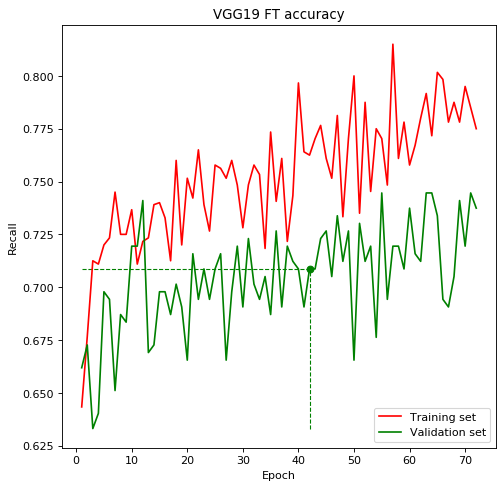

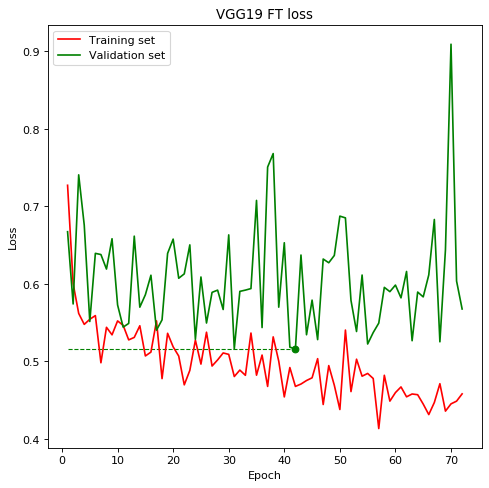

In [18]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [19]:
vgg19_mass_benign_or_malignant_fine_RMSprop3 = models.load_model('../model/vgg19_mass_benign_or_malignant_fine_RMSprop_best2.h5')

for layer in vgg19_mass_benign_or_malignant_fine_RMSprop2.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_mass_benign_or_malignant_fine_RMSprop3.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg19_mass_benign_or_malignant_fine_RMSprop3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [20]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_mass_benign_or_malignant_fine_RMSprop_best3.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [21]:
history_fit = vgg19_mass_benign_or_malignant_fine_RMSprop3.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7559 - recall: 0.6816
Epoch 00001: val_loss improved from inf to 0.58205, saving model to ../model/vgg19_mass_benign_or_malignant_fine_RMSprop_best3.h5
5/5 [==============================] - 11s 2s/step - loss: 0.7130 - recall: 0.6967 - val_loss: 0.5820 - val_recall: 0.6871
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5059 - recall: 0.7288
Epoch 00002: val_loss improved from 0.58205 to 0.55350, saving model to ../model/vgg19_mass_benign_or_malignant_fine_RMSprop_best3.h5
5/5 [==============================] - 10s 2s/step - loss: 0.5038 - recall: 0.7367 - val_loss: 0.5535 - val_recall: 0.7266
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4740 - recall: 0.7832
Epoch 00003: val_loss did not improve from 0.55350
5/5 [==============================] - 10s 2s/step - loss: 0.4762 - recall: 

4/5 [=======================>......] - ETA: 1s - loss: 0.4566 - recall: 0.7773
Epoch 00030: val_loss did not improve from 0.50937
5/5 [==============================] - 10s 2s/step - loss: 0.4488 - recall: 0.7844 - val_loss: 0.7077 - val_recall: 0.7230
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5006 - recall: 0.7441
Epoch 00031: val_loss did not improve from 0.50937
5/5 [==============================] - 11s 2s/step - loss: 0.4837 - recall: 0.7609 - val_loss: 0.7272 - val_recall: 0.7338
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4639 - recall: 0.7715
Epoch 00032: val_loss did not improve from 0.50937
5/5 [==============================] - 11s 2s/step - loss: 0.4590 - recall: 0.7750 - val_loss: 0.6028 - val_recall: 0.7302
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4421 - recall: 0.7924
Epoch 00033: val_loss did not improve from 0.50937
5/5 [==============================] - 11s 2s/step - loss: 0.4401 - reca

In [22]:
models.save_model(vgg19_mass_benign_or_malignant_fine_RMSprop3, '../model/vgg19_mass_benign_or_malignant_fine_RMSprop_end3.h5')

In [23]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_mass_benign_or_malignant_fine_RMSprop3 = models.load_model('../model/vgg19_mass_benign_or_malignant_fine_RMSprop_best3.h5')
test_loss_fe, test_acc_fe = vgg19_mass_benign_or_malignant_fine_RMSprop3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_mass_benign_or_malignant_fine_RMSprop3.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning

Epoch [end]: 36
Epoch [opt]: 6
Valid recall [end]: 0.7158
Valid recall [opt]: 0.7374
Test recall [end]:  0.6373
Test recall [opt]:  0.7288
Valid loss [end]: 0.6488
Valid loss [opt]: 0.5094
Test loss [end]:  0.9312
Test loss [opt]:  0.6060


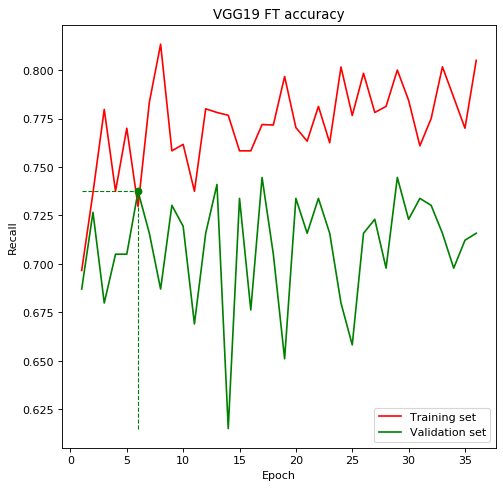

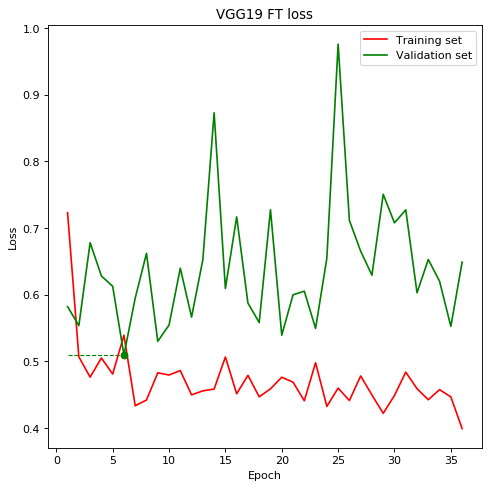

In [24]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();